In [34]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle

warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.__version__, sklearn.__version__

('2.1.1', '1.3.1')

In [35]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [36]:
start_time = time.time()
all_features_2019 = pd.read_parquet(f"{SCRATCH_DIR}/all_features_2019.parquet")
all_features_2019 = all_features_2019[
    all_features_2019["Cancelled"].eq(0) & all_features_2019["Diverted"].eq(0)
]
end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 109.8490 seconds


In [37]:
# Feature selection from "feature_selection_2019_UA-for-real.ipynb"

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    # # Remove based on the intuition that a particular day may have extremely bad weather causing many delays,
    # this guarantees overfitting to the data since this day will never happen again, it doesn't reveal a trend.
    #     "FlightDate",
    "Reporting_Airline",  # we need this to filter out the dataset later
    "Tail_Number",
    "Origin",
    "Dest",
    # "DestCityMarketID", # This is a duplication of origin and dest, which we may filter out anyway later
    # "N-NUMBER",  # Duplication of Tail_Number, we only need a single way to identify the aircraft
    # "MFR MDL CODE", # This is a joining column, duplicate of aircraft manufacturer
    # "ENG MFR MDL", # Code for engine model
    "TYPE REGISTRANT", # Corporations and LLCs
    "NAME",
    "CERTIFICATION", 
    "TYPE ENGINE",
    "STATUS CODE",
    # "MODE S CODE", These identify the aircraft uniquely, we can use tail number
    # "MODE S CODE HEX",
    # "CODE", # Duplicate of the engine model
    "MFR", # Engine manufacturer, condense this
    "MODEL", # Engine model
    "TYPE", # 5 - Fixed wing multi engine
    # "CODE_aircraft", Duplicate of the aircraft manufacturer
    "MFR_aircraft",
    "MODEL_aircraft",
    "TYPE-ENG",
    "BUILD-CERT-IND", # 0 only, we don't care about kit built aircraft
    # "faa_registration_origin", # Tracking column, may be related to registration status
    "Origin_DISPLAY_AIRPORT_NAME",
    "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    "Dest_DISPLAY_AIRPORT_NAME",
    "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
]

In [38]:
delay_cols = [
    "DepDel15",
    "ArrDel15",
    "CarrierDelay",
    "WeatherDelay",
    "NASDelay",
    "SecurityDelay",
    "LateAircraftDelay",
]

# Add delay columns so we can filter later
consolidated_df = all_features_2019[num_cols + cat_cols + delay_cols].copy()

# Identify problematic columns
# for col in consolidated_df.columns:
#     try:
#         consolidated_df[col].astype(float)
#     except ValueError:
#         print(f"Column {col} contains non-convertible values.")

cols_to_convert = [
    "YEAR MFR",
    "TYPE REGISTRANT",
    "TYPE",
    "TYPE-ENG",
    "BUILD-CERT-IND",
]

for col in cols_to_convert:
    try:
        consolidated_df[col] = pd.to_numeric(
            consolidated_df[col].str.strip(), errors="coerce"
        )
    except:
        print(col, "isn't a string")
        consolidated_df[col] = consolidated_df[col].astype("float")

# Clean up some of the weird, non-commercial aircraft registrations
consolidated_df = consolidated_df[
    (  # 7 or 3
        consolidated_df["TYPE REGISTRANT"].eq(7)
        | consolidated_df["TYPE REGISTRANT"].eq(3)
    )
    & (  # 4 or 5
        consolidated_df["TYPE"].eq(4) | consolidated_df["TYPE"].eq(5)
    )  # 4 or 5
    & (consolidated_df["TYPE-ENG"].eq(4) | consolidated_df["TYPE-ENG"].eq(5))
    & consolidated_df["BUILD-CERT-IND"].eq(0)  # 0 only
]

print(consolidated_df.value_counts("TYPE REGISTRANT"))

consolidated_df
# 6997303 rows × 44 columns

TYPE-ENG isn't a string
BUILD-CERT-IND isn't a string
TYPE REGISTRANT
3.0    6831815
7.0     165488
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Origin_DISPLAY_AIRPORT_CITY_NAME_FULL,Dest_DISPLAY_AIRPORT_NAME,Dest_DISPLAY_AIRPORT_CITY_NAME_FULL,DepDel15,ArrDel15,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
24733033,1,1,4,5,1400,1510,70,190,1,2003.0,...,"San Luis Obispo, CA",San Francisco International,"San Francisco, CA",0,0,0,0,0,0,0
24733034,1,1,4,5,0935,1118,103,438,2,2002.0,...,"Houston, TX",Northwest Arkansas National,"Fayetteville, AR",0,0,0,0,0,0,0
24733035,1,1,4,5,0643,0855,132,513,3,2002.0,...,"Springfield, MO",George Bush Intercontinental/Houston,"Houston, TX",0,0,0,0,0,0,0
24733036,1,1,4,5,1335,1433,118,576,3,2002.0,...,"Williston, ND",Denver International,"Denver, CO",0,0,0,0,0,0,0
24733037,1,1,4,5,0836,1040,184,896,4,2014.0,...,"Milwaukee, WI",Denver International,"Denver, CO",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32288695,4,12,1,7,0600,0802,122,762,4,2018.0,...,"Atlanta, GA",LaGuardia,"New York, NY",0,0,0,0,0,0,0
32288696,4,12,1,7,1209,1438,209,1310,6,1999.0,...,"Orlando, FL",Minneapolis-St Paul International,"Minneapolis, MN",1,1,0,0,0,0,23
32288697,4,12,1,7,0650,1110,200,1310,6,1999.0,...,"Minneapolis, MN",Orlando International,"Orlando, FL",0,1,0,0,36,0,0
32288698,4,12,1,7,1639,1932,293,1851,8,2000.0,...,"Washington, DC",Salt Lake City International,"Salt Lake City, UT",0,0,0,0,0,0,0


In [39]:
# BOEING                            2831659
# BOMBARDIER INC                    1262314
# AIRBUS                            1109980
# EMBRAER                            545175
# AIRBUS INDUSTRIE                   544195
# EMBRAER S A                        502448
# MCDONNELL DOUGLAS AIRCRAFT CO      103413
# EMBRAER-EMPRESA BRASILEIRA DE       83212
# MCDONNELL DOUGLAS                   64522
# AIRBUS SAS                          35971
# MCDONNELL DOUGLAS CORPORATION       25896
# C SERIES AIRCRAFT LTD PTNRSP         9258
# AIRBUS CANADA LTD PTNRSP             6573
# CANADAIR                             1948
# GULFSTREAM AEROSPACE CORP             229
# PILATUS AIRCRAFT LTD                   76
# DASSAULT                               75
# GULFSTREAM AEROSPACE                   72
# CESSNA                                 70

consolidated_df["MFR_aircraft"] = (
    consolidated_df["MFR_aircraft"]
    .replace(r".*AIRBUS.*", "AIRBUS", regex=True)
    .replace(r".*EMBRAER.*", "EMBRAER", regex=True)
    .replace(r".*MCDONNELL DOUGLAS.*", "MCDONNELL DOUGLAS", regex=True)
    .replace(r".*YABORA.*", "YABORA", regex=True)
)

mfr_aircraft_replacements = {
    "C SERIES AIRCRAFT LTD PTNRSP": "other",
    "CANADAIR": "other",
    "GULFSTREAM AEROSPACE CORP": "other",
    "PILATUS AIRCRAFT LTD": "other",
    "DASSAULT": "other",
    "GULFSTREAM AEROSPACE": "other",
    "CESSNA": "other",
}

consolidated_df["MFR_aircraft"] = (
    consolidated_df["MFR_aircraft"].str.strip().replace(mfr_aircraft_replacements)
)

consolidated_df.value_counts("MFR_aircraft")

MFR_aircraft
BOEING               2788233
AIRBUS               1675977
BOMBARDIER INC       1229884
EMBRAER              1099758
MCDONNELL DOUGLAS     191941
other                  11510
Name: count, dtype: int64

In [40]:
# CERTIFICATION
# 1T            7086132
# 41              10924
# 1N              10000
# 1                8931
# 1A               4097
# 410              2977
# 40               2397
# 4103             1482
# 1C                 76
# 1NU                70

certification_replacements = {
    "41": "other",
    "1N": "other",
    "1": "other",
    "1A": "other",
    "410": "other",
    "40": "other",
    "4103": "other",
    "1C": "other",
    "1NU": "other",
}

consolidated_df["CERTIFICATION"] = (
    consolidated_df["CERTIFICATION"].str.strip().replace(certification_replacements)
)

consolidated_df.value_counts("CERTIFICATION")

CERTIFICATION
1T       6956983
other      40320
Name: count, dtype: int64

In [41]:
# STATUS CODE
# V     7087375
# 25      31022
# 26       5074
# 28       2099
# 27       1516

status_code_replacements = {
    "25": "other",
    "26": "other",
    "28": "other",
    "27": "other",
}

consolidated_df["STATUS CODE"] = (
    consolidated_df["STATUS CODE"].str.strip().replace(status_code_replacements)
)

consolidated_df.value_counts("STATUS CODE")

STATUS CODE
V        6958080
other      39223
Name: count, dtype: int64

In [42]:
# MFR
# GE            2195782
# CFM INTL      2055793
# CFM INTL.     1165502
# IAE            960007
# ROLLS-ROYC     421279
# ROLLS DEUT      19537
# ROLLS-ROY          10
# P & W          287551
# P&W             20128
# P&W CANADA         70
# IVCHENKO         1276
# WILLIAMS           76
# HONEYWELL          75

mfr_replacements = {
    "CFM INTL.": "CFM INTL",
    "ROLLS-ROYC": "ROLLS-ROYCE",
    "ROLLS DEUT": "ROLLS-ROYCE",
    "ROLLS-ROY": "ROLLS-ROYCE",
    "P&W": "P & W",
    "P&W CANADA": "P & W",
    "IVCHENKO": "other",
    "WILLIAMS": "other",
    "HONEYWELL": "other",
}

consolidated_df["MFR"] = consolidated_df["MFR"].str.strip().replace(mfr_replacements)

consolidated_df.value_counts("MFR")

MFR
CFM INTL       3172698
GE             2142370
IAE             946452
ROLLS-ROYCE     428975
P & W           305393
other             1415
Name: count, dtype: int64

In [43]:
# Checkpoint

# consolidated_df.to_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

# consolidated_df = pd.read_parquet(f"{SCRATCH_DIR}/consolidated_features_2019.parquet")

In [64]:
num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Reporting_Airline",
    "Tail_Number",
    "Origin",
    "Dest",
    "TYPE REGISTRANT",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
    # "TYPE-ENG",
    "BUILD-CERT-IND",
    #
    # Labels only, duplicates of the airport coordinates, also Origin/Dest
    # "Origin_DISPLAY_AIRPORT_NAME",
    # "Origin_DISPLAY_AIRPORT_CITY_NAME_FULL",
    # "Dest_DISPLAY_AIRPORT_NAME",
    # "Dest_DISPLAY_AIRPORT_CITY_NAME_FULL",
    #
    # Only concerned with CarrierDelay for this round
    # "DepDel15",
    # "ArrDel15",
    # "CarrierDelay",
    # "WeatherDelay",
    # "NASDelay",
    # "SecurityDelay",
    # "LateAircraftDelay",
]

In [66]:
# Only concerned with CarrierDelay for this round
united_df = consolidated_df[num_cols + cat_cols + ["CarrierDelay"]].copy()

united_df = united_df[united_df["Reporting_Airline"].eq("UA")]
united_df = united_df[united_df["Origin"].eq("ORD") | united_df["Dest"].eq("ORD")]

# Convert this to "delayed"
united_df["delayed"] = united_df["CarrierDelay"].gt(15)
united_df = united_df.drop("CarrierDelay", axis=1)

# Drop NaNs
united_df = united_df.dropna(how="any", axis="index")

# Drop any features that have all identical values
nunique = united_df.nunique()
united_df = united_df.drop(nunique[nunique.eq(1)].index, axis=1)
united_df["TYPE"] = united_df["TYPE"].astype(int)

print(united_df.columns)
print(united_df.value_counts("delayed"))
# delayed
# False    592267
# True      28434

united_df
# 620701 rows × 31 columns

Index(['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',
       'CRSArrTime', 'CRSElapsedTime', 'Distance', 'DistanceGroup', 'YEAR MFR',
       'HORSEPOWER', 'THRUST', 'NO-SEATS', 'Origin_LATITUDE',
       'Origin_LONGITUDE', 'Dest_LATITUDE', 'Dest_LONGITUDE', 'Tail_Number',
       'Origin', 'Dest', 'NAME', 'CERTIFICATION', 'TYPE ENGINE', 'MFR',
       'MODEL', 'TYPE', 'MFR_aircraft', 'MODEL_aircraft', 'delayed'],
      dtype='object')
delayed
False    146653
True       6907
Name: count, dtype: int64


,Quarter,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,DistanceGroup,YEAR MFR,...,Dest,NAME,CERTIFICATION,TYPE ENGINE,MFR,MODEL,TYPE,MFR_aircraft,MODEL_aircraft,delayed
25272188,1,1,22,2,1315,1932,257,1846,8,2001.0,...,ORD,WELLS FARGO TRUST CO NA TRUSTEE ...,1T,5,ROLLS-ROYCE,RB-211 SERIES,5,BOEING,757-33N,False
25272196,1,1,22,2,1000,1144,164,733,3,2002.0,...,ORD,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B22,5,BOEING,737-700,False
25272197,1,1,22,2,1430,1650,80,296,2,2015.0,...,CMH,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B27E,5,BOEING,737-924ER,False
25272202,1,1,22,2,1011,1200,169,888,4,2004.0,...,DEN,UNITED AIRLINES INC ...,1T,5,ROLLS-ROYCE,RB-211 SERIES,5,BOEING,757-324,False
25272222,1,1,22,2,1423,2024,241,1723,7,2004.0,...,ORD,UMB BANK NA TRUSTEE ...,1T,5,CFM INTL,CFM56 SERIES,5,BOEING,737-824,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32219984,4,12,28,6,1747,2014,207,1197,5,1994.0,...,ORD,U S BANK NA TRUSTEE ...,1T,5,IAE,V2500SERIES,4,AIRBUS,A320-232,False
32219989,4,12,28,6,0755,1049,174,925,4,2014.0,...,IAH,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B27E,5,BOEING,737-924ER,False
32219991,4,12,28,6,2324,0510,226,1739,7,1999.0,...,ORD,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56 SERIES,5,BOEING,737-824,False
32219994,4,12,28,6,0745,1145,180,1120,5,2008.0,...,RSW,UNITED AIRLINES INC ...,1T,5,CFM INTL,CFM56-7B26,5,BOEING,737-924ER,False


In [67]:
# Define features one last time now that the identical values have been removed

num_cols = [
    "Quarter",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "CRSElapsedTime",
    "Distance",
    "DistanceGroup",
    "YEAR MFR",
    "HORSEPOWER",
    "THRUST",
    "NO-SEATS",
    "Origin_LATITUDE",
    "Origin_LONGITUDE",
    "Dest_LATITUDE",
    "Dest_LONGITUDE",
]

cat_cols = [
    "Tail_Number",
    "Origin",
    "Dest",
    "NAME",
    "CERTIFICATION",
    "TYPE ENGINE",
    # "STATUS CODE",
    "MFR",
    "MODEL",
    "TYPE",
    "MFR_aircraft",
    "MODEL_aircraft",
]

In [47]:
# Checkpoint

# weather_df.to_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

# weather_df = pd.read_parquet(f"{SCRATCH_DIR}/weather_features_2019.parquet")

In [68]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

start_time = time.time()

X = united_df.drop("delayed", axis=1)
y = united_df["delayed"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OrdinalEncoder(), cat_cols),
    ]
)

X_transformed = preprocessor.fit_transform(X)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 1.4108 seconds


In [77]:
from sklearn.model_selection import train_test_split

start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    # X_transformed, y, test_size=0.2, random_state=42
    X, y, test_size=0.2, random_state=42
)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Elapsed time: 0.0929 seconds


In [79]:
y_train = (y_train == True).astype(int)
y_test = (y_test == True).astype(int)
y_train

31811259    0
30350342    0
30875164    0
28267967    0
26894179    0
           ..
30870439    0
30335332    0
31117823    0
31808955    0
30878660    0
Name: delayed, Length: 122848, dtype: int64

In [82]:
cat_indices = [X.columns.get_loc(col) for col in cat_cols]

cat_indices

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

In [81]:
from imblearn.over_sampling import SMOTENC

start_time = time.time()

smote = SMOTENC(categorical_features=cat_cols, sampling_strategy="auto", random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

X_res.shape, y_res.shape
# ((947732, 30), (947732,))

Elapsed time: 45.2139 seconds


((234740, 28), (234740,))

In [83]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_res, y_res)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

coefficients = ridge.coef_

feature_importance = list(zip(feature_names, coefficients))

sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

sorted_features

# ('STATUS CODE', -0.1936464635931106),
#  ('CRSDepTime', 0.05396802869037995),
#  ('MFR_aircraft', 0.0529681965594275),
#  ('CRSElapsedTime', -0.04540196665369606),
#  ('TYPE', 0.040896942813453005),
#  ('DistanceGroup', 0.03848265204906631),

ValueError: could not convert string to float: '824UA'

In [21]:
from sklearn.linear_model import Lasso

start_time = time.time()

lasso = Lasso(alpha=0.1)
lasso.fit(X_res, y_res)

feature_names = num_cols + list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
)

important_features = np.nonzero(lasso.coef_)[0]
important_feature_names = [feature_names[i] for i in important_features]


end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

important_feature_names  # :(
# ['Tail_Number', 'MODEL']

Elapsed time: 0.1439 seconds


['Tail_Number', 'Origin', 'Dest', 'MODEL']

In [84]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

def fit_grid_search_cat_boost(fit_X_train, fit_y_train):
    cat_clf = CatBoostClassifier(
        eval_metric="F1",
        auto_class_weights="Balanced",
        cat_features=cat_indices 
    )

    grid_search = GridSearchCV(
        estimator=cat_clf,
        param_grid={
            "learning_rate": [0.01], #, 0.1, 0.2],
            "depth": [5], #[4, 6, 8],
            "iterations": [100],#, 150],
            "l2_leaf_reg": [1, 3, 5],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search

start_time = time.time()

model = fit_grid_search_cat_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.757 total time=  51.3s
[CV 1/5] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.713 total time=  51.9s
[CV 3/5] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.760 total time=  51.8s
[CV 4/5] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.756 total time=  53.2s
[CV 5/5] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01;, score=0.758 total time=  53.1s
[CV 1/5] END depth=5, iterations=100, l2_leaf_reg=3, learning_rate=0.01;, score=0.712 total time=  52.2s
[CV 2/5] END depth=5, iterations=100, l2_leaf_reg=3, learning_rate=0.01;, score=0.755 total time=  51.9s
[CV 3/5] END depth=5, iterations=100, l2_leaf_reg=3, learning_rate=0.01;, score=0.758 total time=  51.3s
[CV 4/5] END depth=5, iterations=100, l2_leaf_reg=3, learning_rate=0.01;, score=0.755 total time=  4

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def fit_grid_search_logistic_regression(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        LogisticRegression(solver="saga", max_iter=1000),
        param_grid={},
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_logistic_regression(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..................................., score=0.568 total time=14.2min
[CV 2/5] END ..................................., score=0.566 total time=14.2min


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..................................., score=0.568 total time=14.2min


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..................................., score=0.567 total time=14.3min


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..................................., score=0.568 total time=14.3min


In [ ]:
# Checkpoint

LOGISTIC_REGRESSION_MODEL = "16_UA_carrier_delays_logistic_regression.pkl"

with open(f"{SCRATCH_DIR}/{LOGISTIC_REGRESSION_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{LOGISTIC_REGRESSION_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [50]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


def fit_grid_search_xg_boost(fit_X_train, fit_y_train):
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        scale_pos_weight=sum(fit_y_train == 0) / sum(fit_y_train == 1),
    )

    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid={
            "learning_rate": [0.01, 0.1, 0.2, 0.3],
            "max_depth": [5, 7, 10],
            "n_estimators": [150],  # , 250, 500],
            "subsample": [0.6, 0.7, 0.8],
            "colsample_bytree": [0.6, 0.7, 0.8],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_xg_boost(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.908 total time=   8.3s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.780 total time=   8.3s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.911 total time=   8.4s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.909 total time=   8.4s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.911 total time=   8.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.782 total time=   8.5s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.909 total time=   8.3s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.911 total time=   8.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.781 total time=   9.5s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.908 total time=   9.5s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.911 total time=   9.6s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.911 total time=   9.6s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.912 total time=   9.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.909 total time=   9.7s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.911 total time=   9.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.804 total time=  12.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.935 total time=  13.2s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.940 total time=  13.2s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.804 total time=  13.3s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.940 total time=  13.4s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.933 total time=  13.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if i

[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.933 total time=  13.6s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.935 total time=  13.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.940 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.802 total time=  16.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.939 total time=  16.6s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.939 total time=  16.8s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.933 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.934 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.939 total time=  16.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.837 total time=  21.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.976 total time=  23.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.838 total time=  20.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.973 total time=  21.3s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.971 total time=  20.8s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.974 total time=  20.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.976 total time=  20.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.973 total time=  20.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.975 total time=  19.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.972 total time=  18.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.852 total time=   9.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.835 total time=  16.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.988 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.976 total time=  17.3s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.972 total time=  17.2s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.974 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.973 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.986 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.986 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.987 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.851 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.988 total time=   9.0s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.986 total time=   9.0s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.852 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.988 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.986 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.987 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.987 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.857 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.992 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.992 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.857 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.992 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  11.0s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.992 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.857 total time=  10.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  10.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.992 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.992 total time=  10.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.863 total time=  14.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.1s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  15.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  15.9s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.862 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  15.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.863 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  15.9s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  15.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.859 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  15.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.994 total time=   9.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.993 total time=   8.7s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  15.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.994 total time=   8.6s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.993 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.859 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   8.6s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.859 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   8.7s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.993 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.863 total time=  10.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.996 total time=  10.9s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.996 total time=  10.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.863 total time=  10.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  10.7s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.996 total time=  12.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.996 total time=  10.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.863 total time=  10.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  10.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  10.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  10.8s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.865 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.998 total time=  16.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.4s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.865 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.3s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  16.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.862 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.865 total time=  13.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   9.3s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.995 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.862 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   9.1s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.862 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.864 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.3s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.864 total time=  10.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.865 total time=  10.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.867 total time=  14.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.867 total time=  14.7s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.996 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.866 total time=  13.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.783 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.916 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.913 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.912 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.915 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.783 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.915 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.911 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.913 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.914 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.782 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.915 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.910 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.912 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.916 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.803 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.936 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.931 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.934 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.935 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.803 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.930 total time=  11.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.934 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.938 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.935 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.803 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.934 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.933 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.934 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.935 total time=  12.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.825 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.960 total time=  17.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.959 total time=  17.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.965 total time=  17.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.963 total time=  17.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.826 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.958 total time=  17.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.959 total time=  17.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.964 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.826 total time=  16.5s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.963 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.850 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.959 total time=  17.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.957 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.964 total time=  17.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.987 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.963 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.987 total time=   9.2s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.986 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.987 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.852 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.986 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.988 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.988 total time=   8.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.851 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.986 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.987 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.987 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.857 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.994 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.992 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  11.1s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.857 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.992 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.857 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.994 total time=  11.2s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.863 total time=  14.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  16.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.863 total time=  14.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.863 total time=  14.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.859 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.993 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.993 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.993 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.859 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.993 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   9.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.859 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.995 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.863 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.3s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.863 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.1s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.863 total time=  10.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.1s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.865 total time=  14.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.998 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.865 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.998 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.865 total time=  14.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.862 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  16.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.862 total time=   8.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   8.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.862 total time=   8.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   8.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   8.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   8.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   8.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.865 total time=  10.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  10.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.864 total time=  10.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.0s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.865 total time=  10.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.867 total time=  14.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  17.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.867 total time=  14.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.996 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.996 total time=  17.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.996 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.867 total time=  13.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.786 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.918 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.915 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.924 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.6;, score=0.928 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.785 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.920 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.916 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.925 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.7;, score=0.919 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.785 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.920 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.921 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.925 total time=   8.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=150, subsample=0.8;, score=0.927 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.809 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.944 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.940 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.938 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.6;, score=0.937 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.811 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.943 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.942 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.942 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.7;, score=0.940 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.810 total time=  10.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.943 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.941 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.940 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=150, subsample=0.8;, score=0.939 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.830 total time=  16.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.956 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.956 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.958 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6;, score=0.956 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.831 total time=  16.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.953 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.958 total time=  17.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.957 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.852 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.825 total time=  16.0s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.7;, score=0.957 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.954 total time=  17.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.957 total time=  17.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.955 total time=  17.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.989 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.8;, score=0.956 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.986 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.987 total time=   9.0s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.6;, score=0.987 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.851 total time=   8.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.989 total time=   9.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=   9.9s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=   9.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7;, score=0.987 total time=  10.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.852 total time=  10.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.988 total time=  10.5s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.987 total time=  10.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.987 total time=  10.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.8;, score=0.988 total time=  10.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.857 total time=  12.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  12.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.992 total time=  12.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  13.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.857 total time=  12.7s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.6;, score=0.993 total time=  12.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.994 total time=  13.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  13.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  13.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.7;, score=0.993 total time=  13.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.857 total time=  12.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.994 total time=  12.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  12.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.994 total time=  11.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=150, subsample=0.8;, score=0.993 total time=  11.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.862 total time=  14.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  16.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.863 total time=  14.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  17.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.863 total time=  14.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.860 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  16.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.993 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.6;, score=0.994 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.860 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.993 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.994 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.7;, score=0.993 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.859 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.995 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.993 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=150, subsample=0.8;, score=0.994 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.863 total time=  10.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.863 total time=  10.8s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.863 total time=  10.9s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.3s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.865 total time=  14.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.4s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.998 total time=  17.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.866 total time=  14.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.6;, score=0.997 total time=  17.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  17.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.866 total time=  14.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.863 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.7;, score=0.998 total time=  17.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  17.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  17.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   9.2s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=150, subsample=0.8;, score=0.998 total time=  17.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.6;, score=0.996 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.863 total time=   8.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.997 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.995 total time=   9.0s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.995 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.7;, score=0.996 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.862 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.997 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   8.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   9.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=0.8;, score=0.996 total time=   9.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.865 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  12.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.6;, score=0.997 total time=  11.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.864 total time=  11.1s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.998 total time=  11.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.7;, score=0.997 total time=  11.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.865 total time=  11.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.998 total time=  11.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.7s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=7, n_estimators=150, subsample=0.8;, score=0.997 total time=  11.8s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.867 total time=  15.4s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  18.6s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  18.9s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.995 total time=  18.5s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.867 total time=  15.0s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.6;, score=0.996 total time=  18.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  18.3s


/Users/Pat/Documents/umich/2023-09 SIADS 696/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  18.5s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  17.9s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.867 total time=  13.4s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.7;, score=0.997 total time=  16.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  15.3s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  15.1s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n_estimators=150, subsample=0.8;, score=0.997 total time=  13.6s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.3, max_depth=10, n

In [ ]:
# Checkpoint

XGBOOST_MODEL = "16_UA_carrier_delays_xgboost.pkl"

with open(f"{SCRATCH_DIR}/{XGBOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{XGBOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


def fit_grid_search_random_forest(fit_X_train, fit_y_train):
    rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_clf,
        param_grid={
            "n_estimators": [100],  # [50, 100, 150],
            "max_depth": [None],  # , 10, 20, 30],
            "min_samples_split": [2],  #  5, 10],
            "min_samples_leaf": [1],  #  2, 4],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )
    
    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search_random_forest(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.016 total time=  23.0s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.020 total time=  23.4s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.007 total time=  23.4s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.018 total time=  23.1s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.016 total time=  23.2s
Elapsed time: 44.9486 seconds


In [ ]:
# Checkpoint

RANDOM_FOREST_MODEL = "16_UA_carrier_delays_random_forest.pkl"

with open(f"{SCRATCH_DIR}/{RANDOM_FOREST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{RANDOM_FOREST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def fit_grid_search_svm(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        estimator=SVC(probability=True),
        param_grid={
            # "C": [0.1, 1, 10],
            # "kernel": ["linear", "rbf"],
            # "gamma": ["auto", "scale"],
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best SVM parameters: ", grid_search.best_params_)
    print("Best SVM score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_svm(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END ..................................., score=0.000 total time= 2.3min
[CV 5/5] END ..................................., score=0.000 total time= 2.4min
[CV 1/5] END ..................................., score=0.000 total time= 2.3min
[CV 4/5] END ..................................., score=0.000 total time= 2.4min
[CV 2/5] END ..................................., score=0.000 total time= 2.4min
Best SVM parameters:  {}
Best SVM score:  0.0
Elapsed time: 233.2491 seconds


In [ ]:
# Checkpoint

SVM_MODEL = "16_UA_carrier_delays_svm.pkl"

with open(f"{SCRATCH_DIR}/{SVM_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{SVM_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier


def fit_grid_search_gradient_boost(fit_X_train, fit_y_train):
    grid_search = GridSearchCV(
        estimator=HistGradientBoostingClassifier(),
        param_grid={
            "learning_rate": [0.1],  # [0.01, 0.1, 0.5],
            "max_iter": [100],  # [50, 100, 200],
            "max_depth": [None],  # [None, 10, 20],
            "min_samples_leaf": [40],  # [20, 40, 60],
            "l2_regularization": [0],  # [0.0, 1.0, 2.0]
        },
        scoring="f1",
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    print("Best HistGradientBoosting parameters: ", grid_search.best_params_)
    print("Best HistGradientBoosting score: ", grid_search.best_score_)

    return grid_search


start_time = time.time()

model = fit_grid_search_gradient_boost(X_train, y_train)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END l2_regularization=0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.002 total time=   1.9s
[CV 3/5] END l2_regularization=0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.002 total time=   2.2s
[CV 4/5] END l2_regularization=0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.000 total time=   2.2s
[CV 2/5] END l2_regularization=0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.000 total time=   2.6s
[CV 5/5] END l2_regularization=0, learning_rate=0.1, max_depth=None, max_iter=100, min_samples_leaf=40;, score=0.000 total time=   3.0s
Best HistGradientBoosting parameters:  {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 40}
Best HistGradientBoosting score:  0.0007292616226071103
Elapsed time: 6.2230 seconds


In [ ]:
# Checkpoint

GRADIENT_BOOST_MODEL = "16_UA_carrier_delays_gradient_boost.pkl"

with open(f"{SCRATCH_DIR}/{GRADIENT_BOOST_MODEL}", "wb") as f:
    pickle.dump(model, f)

# with open(f"{SCRATCH_DIR}/{GRADIENT_BOOST_MODEL}", "rb") as f:
#     model = pickle.load(f)

In [ ]:
from sklearn.metrics import make_scorer, fbeta_score


f_score_half = make_scorer(fbeta_score, beta=0.5)
f_score_one = make_scorer(fbeta_score, beta=1)
f_score_two = make_scorer(fbeta_score, beta=2)

# {
#     "f_score_half": f_score_half,
#     "f_score_one": f_score_one,
#     "f_score_two": f_score_two,
# },
# refit=False,

# For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit
# an estimator with the best parameter setting on the whole data and make the best_* attributes
# available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

# Model Evaluation

In [85]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

y_pred = model.predict(X_test)

# y_pred_proba = model.best_estimator_.predict_proba(X_test)

ra_score = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

# xgboost
# 0.803598235336136

# random forest
# 0.5041971245888275

ra_score

0.550450029079655

[[18631 10652]
 [  765   664]]


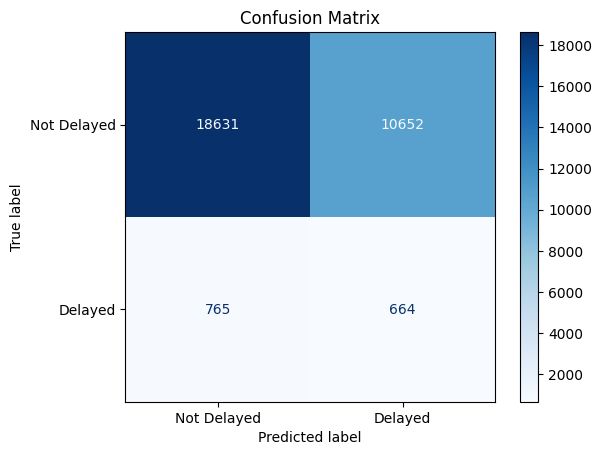

In [86]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

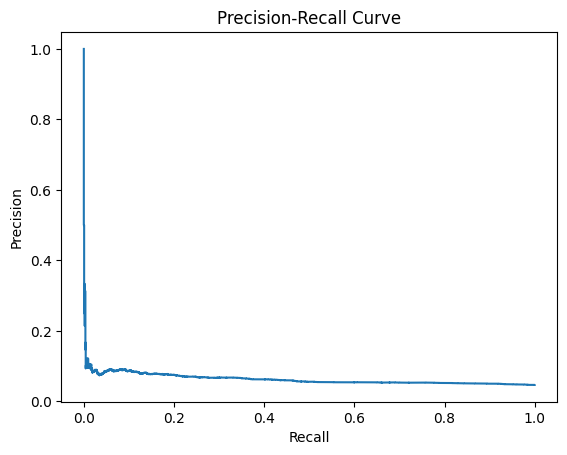

In [87]:
y_scores = model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


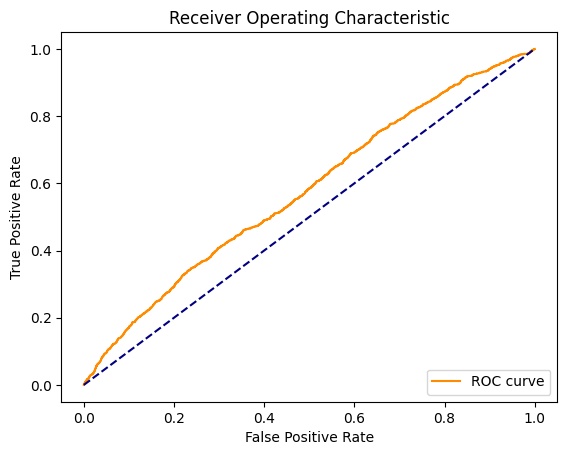

In [88]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [89]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1

(0.6282560562646523,
 0.05867797808412867,
 0.4646606018194542,
 0.10419772459788153)

In [90]:
metrics_scores = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric")),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title="Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

chart

alt.LayerChart(...)